# Constructing Arbitrary Unitary Transformations from Quantum Gates

In [1]:
import qute; import importlib; importlib.reload (qute) # solves issue with CSS
import qiskit
import qiskit.quantum_info as qi
import qiskit.circuit.library as qcl
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
def complexFormatter(z):
    if z==0:                  s = f'{0: .2f}'; c = '\033[37;1m'
    elif np.abs(z.imag)<1e-3: 
        if z.real>1e-3:       s = f'{z.real: .2f}'; c = '\033[31;1m'
        elif z.real<-1e-3:    s = f'{z.real: .2f}'; c = '\033[34;1m'
        else:                 s = f'{0: .2f}'; c = '\033[37;1m'
    else:                     s = f'{z: .2f}'; c = '\033[35;1m' 
    return c + '{:11s}'.format(s) + '\033[0m'
#np.set_printoptions (precision=2,linewidth=200,floatmode='maxprec',suppress=True)
np.set_printoptions (linewidth=200, formatter={'complex_kind':complexFormatter})
print (np.array([[1., -2.],[2+1j,3.0-2j]]))


$~$
$\newcommand{\beq}{\qquad\begin{align}}$
$\newcommand{\eeq}{\end{align}}$
$\newcommand{\half}{\frac{1}{2}}$
$\newcommand{\mean}[1]{\langle #1 \rangle}$
$\newcommand{\bra}[1]{\langle #1 \rvert}$
$\newcommand{\ket}[1]{\lvert #1 \rangle}$
$\newcommand{\adag}{a^\dagger}$
$\newcommand{\vect}[1]{{\underline{\mathbf{#1}}}}$
$\newcommand{\mat}[1]{{\underline{\underline{\mathbf{#1}}}}}$
$\newcommand{\re}{\mathop{\mathrm{Re}}}$
$\newcommand{\im}{\mathop{\mathrm{Im}}}$


$~$
$\newcommand{\beq}{\qquad\begin{align}}$
$\newcommand{\eeq}{\end{align}}$
$\newcommand{\half}{\frac{1}{2}}$
$\newcommand{\mean}[1]{\langle #1 \rangle}$
$\newcommand{\bra}[1]{\langle #1 \rvert}$
$\newcommand{\ket}[1]{\lvert #1 \rangle}$
$\newcommand{\adag}{a^\dagger}$
$\newcommand{\vect}[1]{{\underline{\mathbf{#1}}}}$
$\newcommand{\mat}[1]{{\underline{\underline{\mathbf{#1}}}}}$
$\newcommand{\re}{\mathop{\mathrm{Re}}}$
$\newcommand{\im}{\mathop{\mathrm{Im}}}$


[[ 1.00       -2.00      ]
 [ 2.00+1.00j  3.00-2.00j]]


### Swap $\ket{x}$ and $\ket{y}$

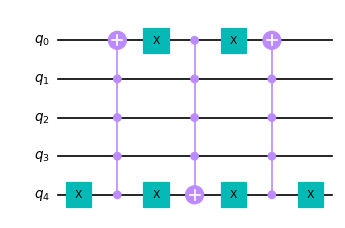

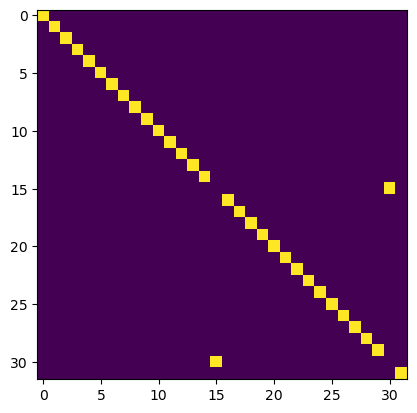

In [2]:
def swapStatesSimple (c, x, i):
    '''
    Given QuantumCircuit c, special register state x=0b01101, and qubit index i=2,
    build circuit that maps |01101> and |01001> to each other but leaves all other states unchanged
    '''
    n = c.num_qubits
    noti = list(range(n)); noti.remove(i)
    for j in noti:
        if not (x>>j)&1: c.x(j)    
    c.mcx(noti, i)
    for j in noti:
        if not (x>>j)&1: c.x(j)
      
def swapStates(c, x, y):
    '''
    Given QuantumCircuit c, state x, and state y (integer),
    build circuit that maps |x> and |y> to each other but leaves all other states unchanged
    '''
    n = c.num_qubits
    pairs = []
    z = x
    for i in range(n):
        if (z>>i)&1 != (y>>i)&1:
            pairs += [[z, i]]
            z ^= (1<<i)
    pairs += pairs[-2::-1]
    for z,i in pairs:
        swapStatesSimple(c,z,i)

n = 5
c = qiskit.QuantumCircuit(n)
swapStates(c, 15, 30)
display( c.draw('mpl',scale=.6) )
U = qi.Operator(c).data
plt.imshow (U.real)
for i in range(2^n):
    j = np.where(U[i] != 0) [0][0]
    if j!=i: print (f'Operation swaps states {i} and {j}')

### RV gate (2x2 rotation on single qubit)

Qiskit's RV gate performs a rotation described by an axis-angle vector $\vect{v}$,

$\beq
\mat{R}_V (v_x, v_y, v_z) 
= \pmatrix{ 
  q_0-i q_3 & -q_2-iq_1 \\
  q_2-iq_1 & q_0+iq_3 
}
= \pmatrix{ 
  \cos\frac{v}{2} - \frac{iv_3}{v} \sin\frac{v}{2} & \frac{-v_2 - iv_1}{v} \sin\frac{v}{2}  \\
  \frac{v_2 - iv_1}{v} \sin\frac{v}{2} & \cos\frac{v}{2} - \frac{iv_3}{v} \sin\frac{v}{2}
}
\eeq$

where $q_0 = \cos \tfrac{v}{2}$ and $q_i = \tfrac{v_i}{v} \sin \tfrac{v}{2}$.  Let's confirm this:

In [3]:
vx,vy,vz = [0.1, 0.3, 0.5]
v = np.sqrt (vx*vx + vy*vy + vz*vz)
q0,q1,q2,q3 = np.cos(v/2),np.sin(v/2)*vx/v,np.sin(v/2)*vy/v,np.sin(v/2)*vz/v
U = np.array([[complex(q0,-q3),complex(-q2,-q1)],[complex(q2,-q1),complex(q0,q3)]])  # homemade 
print (U)
U = qi.Operator( qcl.RVGate(vx, vy, vz) ).data  # canned
print (U)

[[ 0.96-0.25j -0.15-0.05j]
 [ 0.15-0.05j  0.96+0.25j]]
[[ 0.96-0.25j -0.15-0.05j]
 [ 0.15-0.05j  0.96+0.25j]]


### CRV gate (controlled 2x2 rotation with 1 or more control qubits)

Create a controlled axis-angle rotation gate and display its matrix representation:

In [4]:
def CRVGate(vx, vy, vz, nctrl=1):
    return qcl.RVGate(vx, vy, vz).control(nctrl)
 
U = qi.Operator( CRVGate(1,2,3) ).data
print (U)

[[ 1.00        0.000000    0.000000    0.000000  ]
 [ 0.000000   -0.30-0.77j  0.000000   -0.51-0.26j]
 [ 0.000000    0.000000    1.00        0.000000  ]
 [ 0.000000    0.51-0.26j  0.000000   -0.30+0.77j]]


Do this as a circuit:

[[ 1.00        0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000  ]
 [ 0.000000    1.00        0.000000    0.000000    0.000000    0.000000    0.000000    0.000000  ]
 [ 0.000000    0.000000    1.00        0.000000    0.000000    0.000000    0.000000    0.000000  ]
 [ 0.000000    0.000000    0.000000   -0.30-0.77j  0.000000    0.000000    0.000000   -0.51-0.26j]
 [ 0.000000    0.000000    0.000000    0.000000    1.00        0.000000    0.000000    0.000000  ]
 [ 0.000000    0.000000    0.000000    0.000000    0.000000    1.00        0.000000    0.000000  ]
 [ 0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    1.00        0.000000  ]
 [ 0.000000    0.000000    0.000000    0.51-0.26j  0.000000    0.000000    0.000000   -0.30+0.77j]]


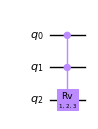

In [5]:
c = qiskit.QuantumCircuit(3); c.append (CRVGate(1,2,3,nctrl=2), [0,1,2])
print (qi.Operator( c ).data)
c.draw ('mpl', scale=.5)

[[ 1.00        0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000  ]
 [ 0.000000    1.00        0.000000    0.000000    0.000000    0.000000    0.000000    0.000000  ]
 [ 0.000000    0.000000    1.00        0.000000    0.000000    0.000000    0.000000    0.000000  ]
 [ 0.000000    0.000000    0.000000    1.00        0.000000    0.000000    0.000000    0.000000  ]
 [ 0.000000    0.000000    0.000000    0.000000    1.00        0.000000    0.000000    0.000000  ]
 [ 0.000000    0.000000    0.000000    0.000000    0.000000    1.00        0.000000    0.000000  ]
 [ 0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   -0.30-0.77j -0.51-0.26j]
 [ 0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.51-0.26j -0.30+0.77j]]


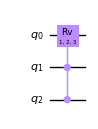

In [6]:
c = qiskit.QuantumCircuit(3); c.append (CRVGate(1,2,3,nctrl=2), [2,1,0])
print (qi.Operator( c ).data)
c.draw ('mpl', scale=.5)

### Givens gate (controlled 2x2 rotation between two arbitrary states $\ket{A}$ and $\ket{B}$)

[[ 1.00        0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000  ]
 [ 0.000000    1.00        0.000000    0.000000    0.000000    0.000000    0.000000    0.000000  ]
 [ 0.000000    0.000000    1.00        0.000000    0.000000    0.000000    0.000000    0.000000  ]
 [ 0.000000    0.000000    0.000000    1.00        0.000000    0.000000    0.000000    0.000000  ]
 [ 0.000000    0.000000    0.000000    0.000000   -0.30-0.77j  0.000000    0.000000   -0.51-0.26j]
 [ 0.000000    0.000000    0.000000    0.000000    0.000000    1.00        0.000000    0.000000  ]
 [ 0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    1.00        0.000000  ]
 [ 0.000000    0.000000    0.000000    0.000000    0.51-0.26j  0.000000    0.000000   -0.30+0.77j]]


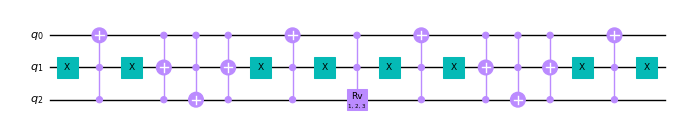

In [7]:
def Givens(c, vx, vy, vz, state0, state1):
    n = c.num_qubits
    state2 = 2**(n-1) - 1  # Note Qiskit conventions!
    state3 = 2**n     - 1  # 
    #print (state2,state3)
    if state0>state1:
        state0,state1=state1,state0     # make sure states are ordered
    if state1==state2:
        swapStates(c, state1, state3)   # swap in this order
        swapStates(c, state0, state2)
        c.append (CRVGate(vx, vy, vz, nctrl=n-1), range(n))
        swapStates(c, state0, state2)
        swapStates(c, state1, state3)
    else:
        swapStates(c, state0, state2)
        swapStates(c, state1, state3)
        c.append (CRVGate(vx, vy, vz, nctrl=n-1), range(n))
        swapStates(c, state1, state3)
        swapStates(c, state0, state2)
        
c = qiskit.QuantumCircuit(3)
Givens (c, 1.0, 2.0, 3.0,  4,7)  # Perform Givens rotation between states 4 and 6
print (qi.Operator( c ).data)
c.draw ('mpl', scale=.5)

### 2x2 Givens rotation to zero a given element of a matrix

For concreteness, suppose $\mat{U}$ is a $4\times 4$ matrix.  Suppose we wish to apply a rotation to states 0 and 1 of this matrix that will introduce a zero in the (1,0) position:

$\beq
\pmatrix{ 
  q_0-i q_3 & -q_2-iq_1 & 0 & 0 \\
  q_2-iq_1 & q_0+iq_3 & 0 & 0 \\
  0 & 0 & 1 & 0 \\
  0 & 0 & 0 & 1
}
\pmatrix{ 
  U_{00} & U_{01} & U_{02} & U_{03} \\
  U_{10} & U_{11} & U_{12} & U_{13} \\
  U_{20} & U_{21} & U_{22} & U_{23} \\
  U_{30} & U_{31} & U_{32} & U_{33} 
}
=
\pmatrix{ 
  . & . & . & . \\
  0 & . & . & . \\
  . & . & . & . \\
  . & . & . & .
}
\eeq$.

This criterion requires that $(q_2-iq_1) U_{00} + (q_0+iq_3) U_{10} = 0$.  We may satisfy this by writing

$\beq
q_2-iq_1 &= -A U_{10} \\
q_0+iq_3 &= +A U_{00} \\
\eeq$
$\quad$so$\quad$
$\beq
q_0 &= A \re U_{00} \\
q_1 &= A \im U_{10} \\
q_2 &= -A \re U_{10} \\
q_3 &= A \im U_{00} 
\eeq$
$\quad$where$\quad$
$A = 1/\sqrt{{q_0}^2 + {q_1}^2 + {q_2}^2 + {q_3}^2}$.

The code below demonstrates that this works:

In [14]:
U = scipy.stats.unitary_group.rvs(4)

i=0; j=1; Uii=U[i,i]; Uji=U[j,i]
q = np.array([Uii.real, Uji.imag, -Uji.real, Uii.imag]); q0,q1,q2,q3 = q/np.linalg.norm(q)
R = np.array([
  [complex(q0,-q3), complex(-q2,-q1), 0, 0],
  [complex(q2,-q1), complex(q0,q3), 0, 0],
  [0, 0, 1, 0],
  [0, 0, 0, 1]
])
print ('R =\n', R)
print ('U =\n', U)
print ('RU =\n', R @ U)

R =
 [[-0.59+0.04j -0.27+0.76j  0.000000    0.000000  ]
 [ 0.27+0.76j -0.59-0.04j  0.000000    0.000000  ]
 [ 0.000000    0.000000    1.00        0.000000  ]
 [ 0.000000    0.000000    0.000000    1.00      ]]
U =
 [[-0.48-0.03j  0.01-0.42j -0.21-0.02j  0.58-0.45j]
 [-0.22-0.62j -0.28-0.33j  0.46+0.34j -0.25+0.01j]
 [ 0.22-0.16j -0.49-0.42j -0.44-0.51j -0.17+0.17j]
 [-0.45+0.26j  0.32-0.34j -0.33+0.26j -0.39+0.43j]]
RU =
 [[ 0.81        0.34+0.13j -0.25+0.26j -0.27+0.09j]
 [ 0.00        0.47+0.10j -0.30-0.38j  0.65+0.32j]
 [ 0.22-0.16j -0.49-0.42j -0.44-0.51j -0.17+0.17j]
 [-0.45+0.26j  0.32-0.34j -0.33+0.26j -0.39+0.43j]]


We can actually implement this using a suitable Givens gate.  Given the quaternion components, we need to derive the axis-angle vector.  Since $q_0 = \cos \tfrac{v}{2}$ and $q_i = \tfrac{v_i}{v} \sin \tfrac{v}{2}$, we have $v = 2 \arccos q_0$ and $v_i = vq_i/\sqrt{1-q_0^2}$



In [15]:
n = 2
U = scipy.stats.unitary_group.rvs(2**n)
#======== Find the quaternion of the Givens rotation.  ARGH, stupid Qiskit conventions
i=0; j=1; Uii=U[i,i]; Uji=U[j,i]
q = np.array([Uii.real, Uji.imag, -Uji.real, Uii.imag]); q0,q1,q2,q3 = q/np.linalg.norm(q)
#======== Find the axis-angle vector
v = 2*np.arccos(q0)
vx,vy,vz = v/np.sin(v/2) * np.array([q1,q2,q3])
#======== Construct the Givens rotation using CR
c = qiskit.QuantumCircuit(n)
Givens (c, vx, vy, vz, i, j)  # Perform Givens rotation between states i and j
R = qi.Operator( c ).data
#======== Dump
print ('R =\n', R)
print ('U =\n', U)
print ('RU =\n', R @ U)

R =
 [[-0.12+0.10j -0.69-0.71j  0.000000    0.000000  ]
 [ 0.69-0.71j -0.12-0.10j  0.000000    0.000000  ]
 [ 0.000000    0.000000    1.00        0.000000  ]
 [ 0.000000    0.000000    0.000000    1.00      ]]
U =
 [[-0.07-0.06j  0.28+0.45j -0.50+0.38j -0.53+0.17j]
 [-0.42+0.43j -0.20-0.63j -0.32+0.02j -0.30+0.04j]
 [-0.11-0.20j -0.23+0.02j  0.63-0.09j -0.70+0.07j]
 [-0.44-0.62j -0.47-0.02j -0.14+0.27j  0.26+0.19j]]
RU =
 [[ 0.61       -0.39+0.55j  0.26+0.12j  0.28+0.11j]
 [ 0.00        0.47+0.21j -0.03+0.65j -0.21+0.52j]
 [-0.11-0.20j -0.23+0.02j  0.63-0.09j -0.70+0.07j]
 [-0.44-0.62j -0.47-0.02j -0.14+0.27j  0.26+0.19j]]


### Many Givens rotations

For whatever reason, only the very last element is phase...

In [16]:
n = 3   # change this to 2 or 3
U0 = scipy.stats.unitary_group.rvs(2**n)

In [17]:
cFull = qiskit.QuantumCircuit(n)
U = U0
for i in range(2**n):
    for j in range(i+1,2**n):
        Uii=U[i,i]; Uji=U[j,i]
        q = np.array([Uii.real, Uji.imag, -Uji.real, Uii.imag]); q0,q1,q2,q3 = q/np.linalg.norm(q)
        v = 2*np.arccos(q0)
        vx,vy,vz = v/np.sin(v/2) * np.array([q1,q2,q3])
        
        c = qiskit.QuantumCircuit(n)
        Givens (c, vx, vy, vz, i, j) ; Givens (cFull, vx, vy, vz, i, j)
        R = qi.Operator( c ).data

        U = R @ U
        print (f'Applied Givens({vx},{vy},{vz},{i},{j}).  Now U = \n',U)
phase = np.angle (U[-1,-1])
c = qiskit.QuantumCircuit(n)
c.mcp (-phase, list(range(n-1)), n-1) ; cFull.mcp (-phase, list(range(n-1)), n-1) 
R = qi.Operator( c ).data
U = R @ U
print (f'Applied MCP.  Now U = \n',U)

Applied Givens(-0.17956419914202604,-0.12410992701031762,-0.7159731039414164,0,1).  Now U = 
 [[ 0.62       -0.10-0.41j -0.22+0.31j -0.13-0.06j -0.08+0.01j -0.07+0.26j -0.07-0.25j -0.30+0.16j]
 [ 0.00        0.37-0.29j  0.30+0.25j  0.20-0.24j  0.66-0.18j  0.07+0.00j -0.17-0.03j  0.16+0.01j]
 [-0.11+0.24j -0.54+0.04j  0.04-0.27j  0.03-0.31j  0.39+0.20j -0.20-0.16j  0.03-0.23j -0.17+0.36j]
 [ 0.28-0.22j  0.22+0.17j  0.13-0.32j  0.03+0.36j  0.12-0.22j  0.13-0.45j -0.02-0.37j -0.35+0.06j]
 [-0.13-0.23j  0.09+0.33j -0.05+0.24j  0.21-0.47j -0.11-0.34j  0.11+0.12j  0.41-0.01j -0.36+0.19j]
 [-0.06-0.54j  0.15-0.05j  0.03-0.24j -0.39-0.11j  0.21+0.20j -0.43+0.23j  0.24-0.08j -0.05-0.26j]
 [ 0.11+0.17j  0.08+0.16j  0.56-0.24j  0.33+0.08j -0.20+0.01j -0.22+0.55j -0.13-0.14j -0.08+0.05j]
 [ 0.12-0.06j -0.10-0.20j -0.08-0.12j  0.26+0.22j  0.02-0.12j  0.04+0.08j  0.62-0.24j  0.54+0.20j]]
Applied Givens(0.7207840867261202,0.32641903749652873,3.194314811250804e-16,0,2).  Now U = 
 [[ 0.67        0.01-

UFull = 
 [[-0.19+0.11j -0.02+0.07j  0.59+0.05j -0.26+0.14j -0.00-0.06j -0.33-0.27j -0.13+0.21j -0.35+0.37j]
 [-0.11-0.35j -0.39-0.39j -0.16+0.14j -0.24+0.26j -0.45+0.08j -0.30+0.21j  0.19+0.06j -0.08-0.08j]
 [-0.27+0.01j -0.02+0.22j -0.31-0.07j  0.17-0.07j -0.41+0.12j  0.08-0.63j  0.26+0.17j  0.13+0.19j]
 [-0.10+0.02j -0.11+0.13j  0.51+0.01j  0.30-0.07j -0.26-0.28j -0.13-0.03j  0.10+0.11j  0.28-0.59j]
 [ 0.28+0.38j -0.15+0.19j -0.33-0.01j  0.07+0.52j -0.08-0.08j -0.18-0.16j -0.39+0.09j -0.17-0.28j]
 [ 0.38+0.22j -0.36-0.44j  0.22-0.02j  0.34-0.17j -0.18+0.10j  0.06-0.22j -0.09-0.37j -0.03+0.22j]
 [ 0.17-0.18j  0.18+0.43j  0.03+0.13j -0.13+0.11j -0.39-0.33j -0.03+0.08j  0.01-0.60j  0.02+0.20j]
 [-0.45-0.23j -0.02-0.11j -0.21-0.19j  0.46-0.04j  0.24-0.30j -0.38-0.03j -0.19-0.28j -0.20+0.04j]]
U0 = 
 [[-0.19+0.11j -0.02+0.07j  0.59+0.05j -0.26+0.14j -0.00-0.06j -0.33-0.27j -0.13+0.21j -0.35+0.37j]
 [-0.11-0.35j -0.39-0.39j -0.16+0.14j -0.24+0.26j -0.45+0.08j -0.30+0.21j  0.19+0.06j -0.08

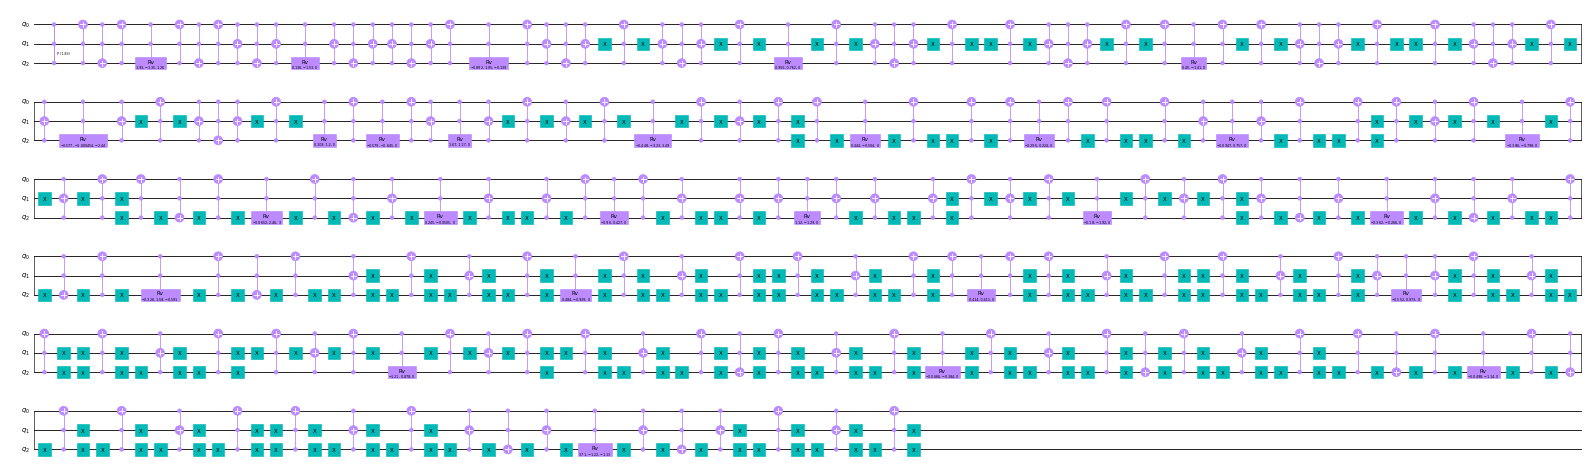

In [37]:
cFull = cFull.inverse()
UFull = qi.Operator( cFull ).data
print ('UFull = \n', UFull)
print ('U0 = \n', U0)
cFull.draw ('mpl', scale=.3, fold=80)

The above shows that the arbitrary $U(8)$ matrix $U_0$ can indeed be decomposed in terms of X, CX, MCP, and RV gates.

My construction is very inefficient, but at least it works.